In [1]:
import numpy as np
from numpy import sin, cos, pi
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

![Creating equations of motion for a spinning top](../images/17_top.png)

# Solving the equations of motion for a spinning top

In this notebook, you will use the differential equations of motion for a spinning top. You will 
- create a function that returns the derivative of the state in the form $\dot{\mathbf{y}} = f(\mathbf{y})$
- use `solve_ivp` to integrate the initial value problem
- compare the solution to the predicted result $\dot{\phi} = \frac{mgd}{I_z\dot{\psi}}$

## Background and setup
In this [lecture video](https://youtu.be/PyExwBFaC3A), you choose 3 generalized coordinates, then determine 3 coupled differential equations for a top that is spinning on a fixed origin. The generalized coordinates represent 3 types of motion for the spinning top:

- $\psi$ - spin angle (how much the top has rotated)
- $\phi$ - precession (the rotation of the whole system around the fixed point)
- $\theta$ - nutate (the angle that the top is rotated away from vertical)

The position of the top's center of mass is 

$\mathbf{r}_{G} = x\hat{i} + y\hat{j} +z \hat{k}$

where

- $x = d\sin(\theta)\cos(\phi)$
- $y = d\sin(\theta)\sin(\phi)$
- $z = d\cos(\theta)$

The Lagrangian for the spinning top is as follows:

$L = T-V= \frac{1}{2}\mathbf{\omega I_O\omega} - mgz$

where 

- $\mathbf{\omega} = \dot{\theta}\hat{i}' + \dot{\phi}\sin\theta\hat{j}' + (\dot{\phi}\cos\theta +\dot{\psi})\hat{k}'$
- $\mathbf{I_O} = \left[\begin{array} 
                            ~I_x +md^2 & 0 & 0\\
                            0 & I_y +md^2 & 0\\
                            0 & 0 & I_z \end{array}\right]$
- assuming $I_x=I_y$, then $I_O = I_x +md^2$

## Equations of motion

### General equations
Leading to two first-order differential equations that describe conservation of angular momentum and one second order differential equation as such

1.  $\frac{\partial L}{\partial \dot{\phi}} = \dot{\phi}(I_O\sin^2\theta+I_z\cos^2\theta) +I_z\dot{\psi}\cos\theta = cst = p_\phi$
2. $\frac{\partial L}{\partial \dot{\psi}} = I_z(\dot{\psi}+\dot{\phi}\cos\theta) = cst = p_\psi$
3.  $I_O\ddot{\theta} - \dot{\phi}^2\sin\theta\cos\theta(I_O-I_z)+\dot{\phi}\dot{\psi}I_z\sin\theta-mgd\sin\theta = 0$

![spinning disk top](../images/disk-top.svg)

Consider a slender support, connected to a spinning disk where

- $m=0.1~kg$
- $r=0.1~m$
- $d = 2r = 0.2~m$

In [2]:
m = 0.1
r = 0.1
d = 2*r

In [3]:
def top_ode(t, y, spin=500, theta0=pi/6, d = d):
    '''
    
    top_ode(t, y, spin, theta0, d):
        
    Return the derivative for a spinning top fixed to the origin with center of
    mass at distance, `d`, from the origin
    
    Parameters
    ----------
    t: current time
    y: current state = y = [phi, psi, theta, dtheta/dt]
    spin: initial spin rate (optional) default is 500 rad/s
    theta0: initial nutation angle (optional) default is 30 deg, pi/6
    d: distance from origin to center of mass (optional) default uses defined d value
    
    Returns
    -------
    dy: derivative of state, y, at time, t 
        [dphi/dt, dpsi/dt, dtheta/dt, ddtheta/ddt]
    '''
    Io = 1/4*m*r**2+m*d**2
    Iz = 1/2*m*r**2
    dy = np.zeros(y.shape)
    
    Pphi = Iz*spin*cos(theta0)
    Ppsi = Iz*spin
    
    DP = (Io*sin(y[2])**2+Iz*cos(y[2])**2)*Iz - Iz**2*cos(y[2])**2
    
    if spin>0.001:
        # if the rate of spin is ~0, then the conservation of angular momentum
        # equations will be singular and should be replaced by 0's
        dy[0] = (Iz*Pphi - Iz*cos(y[2])*Ppsi)/DP
        dy[1] = (-Iz*cos(y[2])*Pphi + (Io*sin(y[2])**2+Iz*cos(y[2])**2)*Ppsi)/DP
    
    dy[2] = y[3]
    dy[3] = dy[0]**2*sin(y[2])*cos(y[2])*(Io-Iz)-\
            dy[0]*dy[1]*Iz*sin(y[2])+\
            m*9.81*d*sin(y[2])
    dy[3] = dy[3]/Io
    
    return dy

### Precession for high spinning rate

In equation (3), if $\dot{\psi}>>\dot{\theta},~\dot{\phi},~\ddot{\theta}$, then the equations simplify to one relationship between $\dot{\psi}~and~\dot{\phi}$, spin and precession, respectively. 

$\dot{\phi} = \frac{mgd}{I_z\dot{\psi}}~\frac{rad}{s}$

You will use the precession time period, $T_{precess} = \frac{2\pi}{\dot{\phi}}~s$ as the solution interval, `[0, T]`. 

In [4]:
Io = 1/4*m*r**2+m*d**2
Iz = 1/2*m*r**2
spin = 500
Iz = 1/2*m*r**2
phi = m*9.81*d/Iz/spin
print('phi = {:.3f} rad/s'.format(phi))
print('phi = {:.3f} cycles/s'.format(phi/2/pi))
print('precession time period {:.2f}'.format(2*pi/phi), ' s')

phi = 0.785 rad/s
phi = 0.125 cycles/s
precession time period 8.01  s


## Solve for the state over time

Here, you use the `solve_ivp` integration to solve for the state as a function of time, 

$state = [\phi,~\psi,~\theta,~\dot{\theta}]$ over time, $t=\left[0...\frac{2\pi}{\dot{\phi}}\right]$



In [5]:
spin = 500
theta0 = pi/6
T = 2*pi*Iz*spin/(m*9.81*d)
sol = solve_ivp(lambda t, y: top_ode(t,y, spin = spin, theta0 = theta0), 
                [0,T], 
                np.array([0, 0, theta0, 0]), 
                t_eval=np.linspace(0,T,1000))

### Verify solution

Here, you expect the result that $\dot{\phi}\dot{\psi}=cst$. So, if you plot $\phi(t)-vs-\psi(t)$, you should see a straight line if $\dot{\psi}$ is very large. 

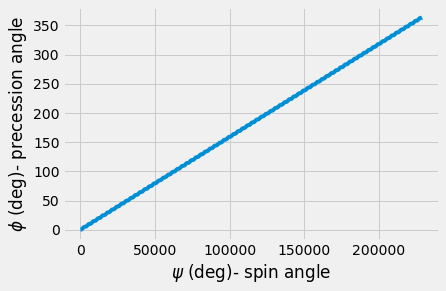

In [6]:
plt.plot(sol.y[1]*180/pi, sol.y[0]*180/pi)
plt.xlabel(r'$\psi$ (deg)- spin angle')
plt.ylabel(r'$\phi$ (deg)- precession angle');

## Look at position of top

Here, use the solution of the state variable, `sol.y` to plug into the kinematic equations for the position of the top over time. You should expect a cosine and sine for $x(t)~and~y(t)$, respectively. The solution should plot one full period, since you used the time period of precession as the end time in `solve_ivp`. 

In [7]:
x = d*sin(sol.y[2])*cos(sol.y[0])
y = d*sin(sol.y[2])*sin(sol.y[0])
z = d*cos(sol.y[2])

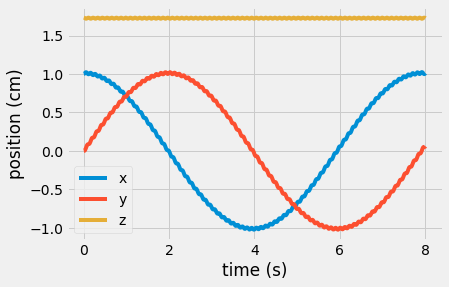

In [8]:
plt.plot(sol.t, 10*x, label = 'x')
plt.plot(sol.t, 10*y, label = 'y')
plt.plot(sol.t, 10*z, label = 'z')
plt.xlabel('time (s)')
plt.ylabel('position (cm)')
plt.legend();


## Animate the motion of the top

In the next code cells, you will set up a 2D animation to watch the top nutate and precess around the origin. You will plot the position of the center of mass for each point in time and plot a line for the path it has followed up until the current time. 

In [9]:
from matplotlib import animation
from IPython.display import HTML

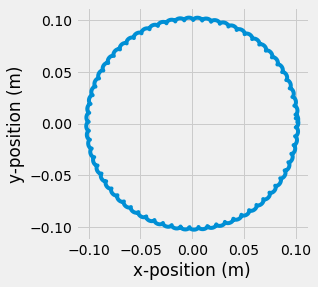

In [10]:
fig, ax = plt.subplots()
line, = ax.plot(x, y)
marker, = ax.plot([], [], '+', markersize=30)
S = x.max()*1.1
ax.set(xlim=(-S, S))
ax.set_aspect('equal')
ax.set_xlabel('x-position (m)')
ax.set_ylabel('y-position (m)');

2. Create an initializing (`init`) function that clears the previous line and marker

In [11]:
def init():
    line.set_data([], [])
    marker.set_data([], [])
    return (line,marker,)

3. Create an animating (`animate`) function that updates the line

In [12]:
def animate(i):
    '''function that updates the line and marker data
    arguments:
    ----------
    i: index of timestep
    outputs:
    --------
    line: the line object plotted in the above ax.plot(...)
    marker: the marker for the end of the 2-bar linkage plotted above with ax.plot('...','o')'''
    line.set_data(x[:i], y[:i])
    marker.set_data(x[i], y[i])
    return (line, marker, )

4. Create an animation (`anim`) variable using the `animation.FuncAnimation`

In [13]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=range(0,len(x)), interval=10, 
                               blit=True)

In [14]:
HTML(anim.to_html5_video())

## Wrapping up

In this notebook, you solved for the position of a spinning top by considering 
- spin, $\dot{\psi}$
- precession, $\dot{\phi}$
- nutation, $\dot{\theta}$

You compared approximate solutions for two cases when the top is spinning fast:
- analytical approximation using a limit
- numerical integration of the exact differential equations